In [1]:
#preprocessing = download and clean data, construct features , investigate and remove high correlation features

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from pylab import plt
%matplotlib inline
pd.set_option('display.max_columns', None)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.datasets import make_blobs

ModuleNotFoundError: No module named 'yfinance'

In [ ]:
ITC_data = yf.download("ITC.NS", start="2004-01-01", end="2024-01-31", period = '1d')


[*********************100%%**********************]  1 of 1 completed


In [ ]:
ITC_data.shape

(4968, 6)

In [ ]:
ITC_adj_close = ITC_data['Adj Close']

Text(0, 0.5, 'Adjusted Close Price, INR')

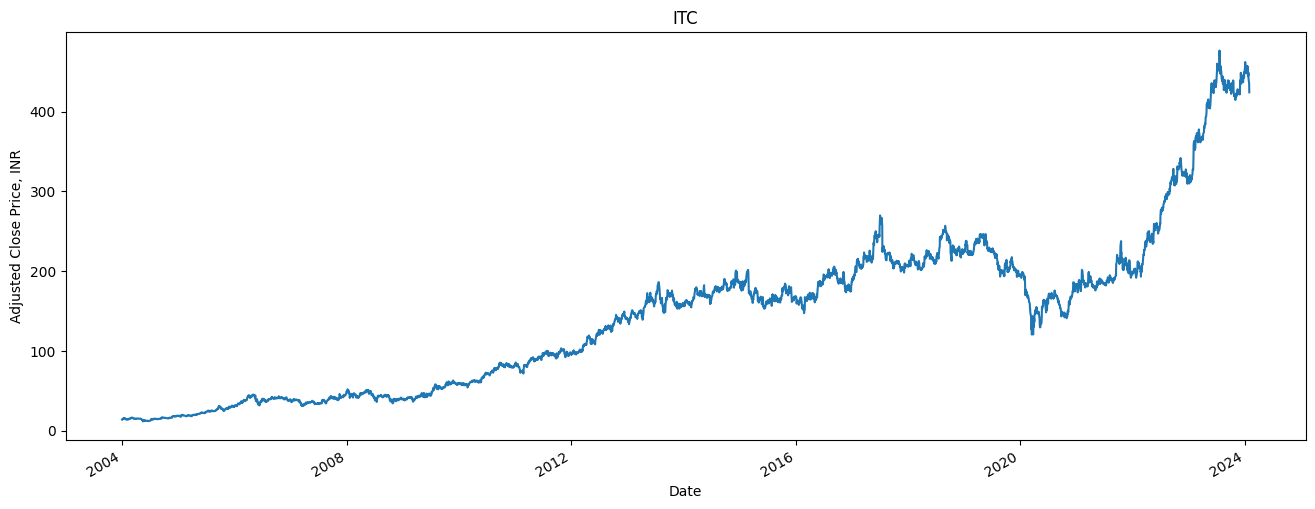

In [ ]:
ITC_adj_close.plot(figsize=(16, 6))
plt.title('ITC')
plt.ylabel('Adjusted Close Price, INR')

In [ ]:
#feature building and selection

In [ ]:
df = pd.DataFrame() # created empty data frame
df['return'] = np.log(ITC_adj_close / ITC_adj_close.shift(1)) # log returns
df['return_sign'] = np.sign(df['return'])# CREATE VARIABLE FOR POSITIVE OR NEGATIVE PRICE MOVEMENT

In [ ]:
df['Adj Close'] = ITC_data['Adj Close'].shift(1)  # Adjusted close price shifted by one day
df['Open'] = ITC_data.Open.shift(1)  # Open price shifted by one day
df['Close'] = ITC_data.Close.shift(1)  # Close price shifted by one day
df['High'] = ITC_data.High.shift(1)  # High price shifted by one day
df['Low'] = ITC_data.Low.shift(1)  # Low price shifted by one day
df['Volume'] = ITC_data.Volume.shift(1)  # Volume shifted by one day

# Function to calculate exponential moving average (EMA)
def EMAcreate(price, period):
    modifiedPrice = price.copy()
    sma_period = price.rolling(period).mean()  # Calculate the simple moving average over the given period
    modifiedPrice.iloc[0:period] = sma_period[0:period]  # Initialize EMA with SMA values
    ema_period = modifiedPrice.ewm(span=period, adjust=False).mean()  # Compute the EMA over the given period
    return ema_period

# Creating lagged returns
lags = 8
cols = []
for lag in range(1, lags+1):
    col_ret = 'ret_%d' % lag
    df[col_ret] = df['return'].shift(lag)  # Create a new column for each lagged return
    cols.append(col_ret)
df['ret_over_5d'] = np.log(df['Adj Close'] / df['Adj Close'].shift(5))  # 5-day log return
df['ret_over_21d'] = np.log(df['Adj Close'] / df['Adj Close'].shift(21))  # 21-day log return
df['MOM_1d'] = df['Adj Close'].diff(1)  # 1-day momentum (difference in adjusted close price)
df['MOM_5d'] = df['Adj Close'].diff(5)  # 5-day momentum (difference in adjusted close price)
df['MA_5d'] = df['Adj Close'].rolling(5).mean()  # 5-day moving average of adjusted close price
df['EMA_7d'] = EMAcreate(df['Adj Close'], 7)  # 7-day exponential moving average of adjusted close price
df['std_21d'] = df['ret_1'].rolling(21).std()  # 21-day rolling standard deviation of 1-day log returns
df.dropna(inplace=True)  # Remove rows with missing values


In [ ]:
 df.tail()

,return,return_sign,Adj Close,Open,Close,High,Low,Volume,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_over_5d,ret_over_21d,MOM_1d,MOM_5d,MA_5d,EMA_7d,std_21d
Date,,,,,,,,,,,,,,,,,,,,,,,
2024-01-23,-0.026216,-1.0,456.577148,468.549988,471.500000,473.000000,466.399994,12203322.0,0.012807,-0.002360,-0.012142,0.010001,0.001927,0.008716,-0.001404,-0.002694,0.010232,0.044452,5.810089,4.648071,453.865784,453.342494,0.008654
2024-01-24,0.009319,1.0,444.763275,473.750000,459.299988,473.750000,456.399994,8404513.0,-0.026216,0.012807,-0.002360,-0.012142,0.010001,0.001927,0.008716,-0.001404,-0.017910,0.017239,-11.813873,-8.037354,452.258313,451.197689,0.010640
2024-01-25,-0.017297,-1.0,448.927216,460.100006,463.600006,467.399994,458.100006,21626183.0,0.009319,-0.026216,0.012807,-0.002360,-0.012142,0.010001,0.001927,0.008716,-0.018592,0.018285,4.163940,-8.424591,450.573395,450.630071,0.010679
2024-01-29,-0.012922,-1.0,441.228821,463.549988,455.649994,464.950012,452.100006,19677700.0,-0.017297,0.009319,-0.026216,0.012807,-0.002360,-0.012142,0.010001,0.001927,-0.023747,-0.001754,-7.698395,-10.603455,448.452704,448.279758,0.011376
2024-01-30,-0.026470,-1.0,435.563965,455.899994,449.799988,457.250000,447.500000,17869152.0,-0.012922,-0.017297,0.009319,-0.026216,0.012807,-0.002360,-0.012142,0.010001,-0.034309,-0.016099,-5.664856,-15.203094,445.412085,445.100810,0.011707


In [ ]:
#we remove enteries with zero returns in the following way
df = df.loc[~(df==0.0).all(axis=1)]
df = df[df!=0].dropna()
np.unique(np.array(df['return_sign']))

array([-1.,  1.])

In [ ]:
df.shape

(4634, 23)

In [ ]:
# Replace -1 with 0 in the 'return_sign' column
for i in range(len(df)):

  if 0<df['return'].iloc[i]<0.0025:
    df['return_sign'].iloc[i]=-1
df['return_sign'].replace(-1, 0, inplace=True)
df.tail(20)


,return,return_sign,Adj Close,Open,Close,High,Low,Volume,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_over_5d,ret_over_21d,MOM_1d,MOM_5d,MA_5d,EMA_7d,std_21d
Date,,,,,,,,,,,,,,,,,,,,,,,
2024-01-01,0.012794,1.0,447.474670,464.100006,462.100006,467.899994,461.350006,12888266.0,-0.004319,0.015198,0.001423,0.002742,0.008272,0.000997,-0.011245,0.009805,0.023317,0.055391,-1.936707,10.312927,444.463110,444.040121,0.012413
2024-01-02,0.004902,1.0,453.236359,463.500000,468.049988,469.950012,462.649994,9346277.0,0.012794,-0.004319,0.015198,0.001423,0.002742,0.008272,0.000997,-0.011245,0.027838,0.071392,5.761688,12.443298,446.951770,446.339180,0.012527
2024-01-03,0.014563,1.0,455.463562,470.000000,470.350006,471.350006,463.600006,10519771.0,0.004902,0.012794,-0.004319,0.015198,0.001423,0.002742,0.008272,0.000997,0.029998,0.044674,2.227203,13.460052,449.643781,448.620276,0.010748
2024-01-04,-0.001783,0.0,462.145203,470.250000,477.250000,480.700012,469.350006,24036012.0,0.014563,0.004902,0.012794,-0.004319,0.015198,0.001423,0.002742,0.008272,0.043138,0.049833,6.681641,19.512268,453.546234,452.001507,0.010979
2024-01-05,-0.005156,0.0,461.322083,480.000000,476.399994,481.450012,474.200012,11786959.0,-0.001783,0.014563,0.004902,0.012794,-0.004319,0.015198,0.001423,0.002742,0.026158,0.053129,-0.823120,11.910706,455.928375,454.331651,0.010890
2024-01-08,-0.017990,0.0,458.949615,479.399994,473.950012,479.399994,472.000000,9209405.0,-0.005156,-0.001783,0.014563,0.004902,0.012794,-0.004319,0.015198,0.001423,0.025321,0.022835,-2.372467,11.474945,458.223364,455.486142,0.009686
2024-01-09,-0.002043,0.0,450.767059,475.000000,465.500000,475.500000,464.549988,8003177.0,-0.017990,-0.005156,-0.001783,0.014563,0.004902,0.012794,-0.004319,0.015198,-0.005463,0.016025,-8.182556,-2.469299,457.729504,454.306372,0.010216
2024-01-10,-0.002694,0.0,449.847107,467.500000,464.549988,469.950012,463.649994,5696780.0,-0.002043,-0.017990,-0.005156,-0.001783,0.014563,0.004902,0.012794,-0.004319,-0.012408,0.033712,-0.919952,-5.616455,456.606213,453.191555,0.009112
2024-01-11,-0.001404,0.0,448.636688,464.549988,463.299988,466.750000,460.049988,5896123.0,-0.002694,-0.002043,-0.017990,-0.005156,-0.001783,0.014563,0.004902,0.012794,-0.029666,0.023698,-1.210419,-13.508514,453.904510,452.052839,0.009060


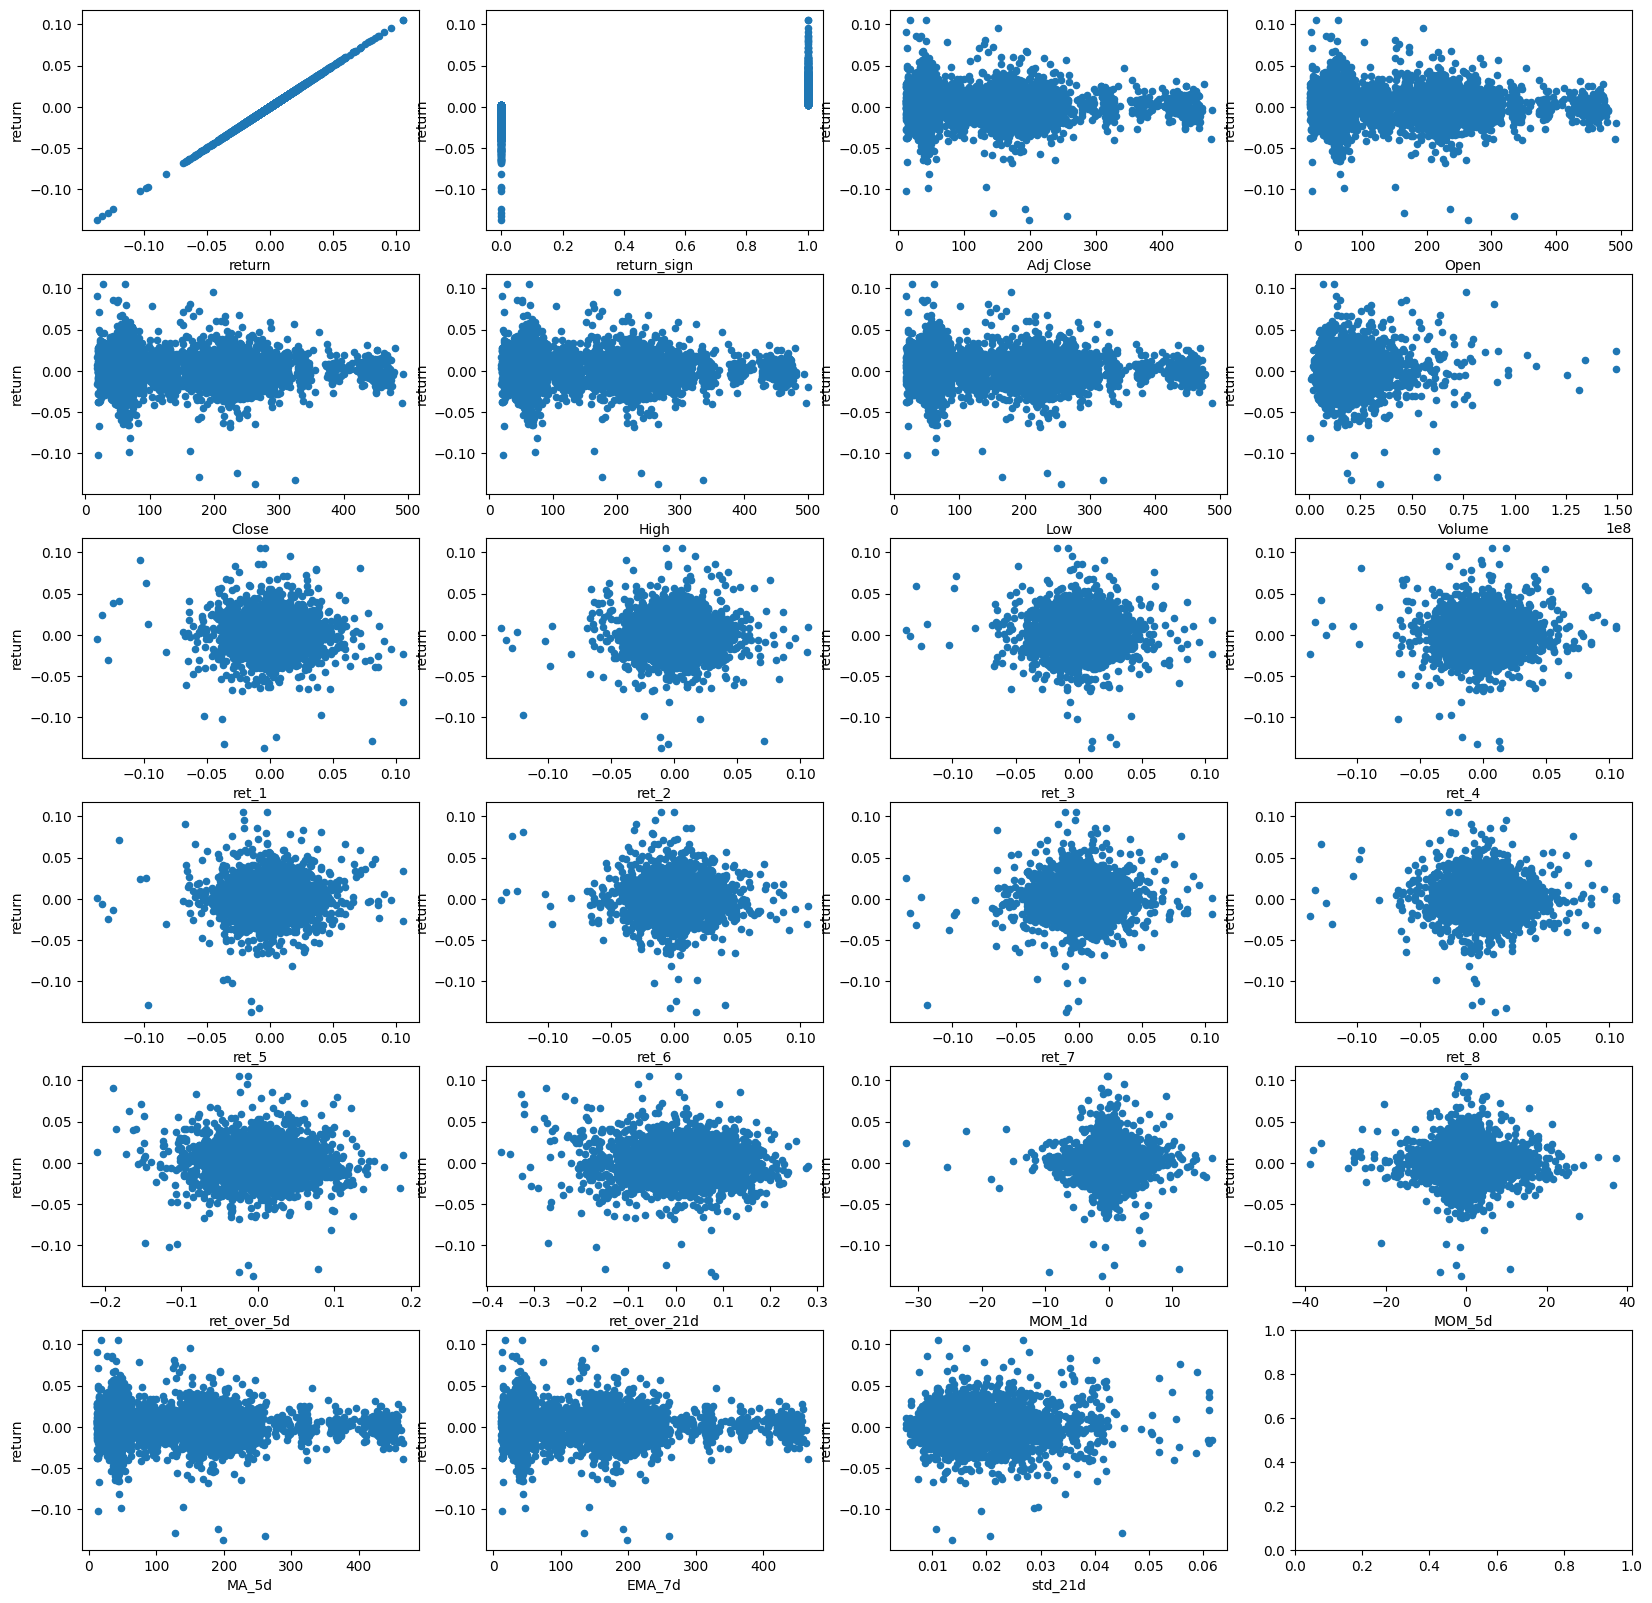

In [ ]:
#plotting effect of different features on the stock return daily
fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20))
for idx, feature in enumerate(df.columns):
    df.plot(feature, "return", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

In [ ]:
df.iloc[:,2:].corr()

,Adj Close,Open,Close,High,Low,Volume,ret_1,ret_2,ret_3,ret_4,ret_5,ret_6,ret_7,ret_8,ret_over_5d,ret_over_21d,MOM_1d,MOM_5d,MA_5d,EMA_7d,std_21d
Adj Close,1.000000,0.987364,0.987670,0.987408,0.987663,-0.094200,0.003431,0.005541,0.007281,0.006536,0.008742,0.007828,0.006993,0.004195,0.014966,0.016292,0.039618,0.098703,0.999619,0.999608,-0.380352
Open,0.987364,1.000000,0.999640,0.999825,0.999791,-0.128008,-0.017093,0.005444,0.006256,0.006053,0.008456,0.006910,0.006518,0.002683,0.004354,0.004804,0.014044,0.082631,0.987554,0.987572,-0.386964
Close,0.987670,0.999640,1.000000,0.999847,0.999826,-0.126773,0.003045,0.004860,0.006465,0.005551,0.007886,0.006831,0.006217,0.003066,0.013198,0.009092,0.037816,0.092787,0.987385,0.987439,-0.387852
High,0.987408,0.999825,0.999847,1.000000,0.999748,-0.121962,-0.006607,0.004855,0.006631,0.005894,0.008386,0.006691,0.006174,0.002912,0.009107,0.006477,0.026366,0.088447,0.987347,0.987380,-0.384481
Low,0.987663,0.999791,0.999826,0.999748,1.000000,-0.132803,-0.006172,0.005547,0.006750,0.005803,0.008243,0.006769,0.006539,0.003077,0.009587,0.008122,0.026802,0.088043,0.987598,0.987634,-0.390864
Volume,-0.094200,-0.128008,-0.126773,-0.121962,-0.132803,1.000000,0.080692,0.031707,0.029527,0.026856,0.010450,0.004916,-0.016640,-0.005442,0.084980,0.000792,0.061582,0.094010,-0.096826,-0.096966,0.303382
ret_1,0.003431,-0.017093,0.003045,-0.006607,-0.006172,0.080692,1.000000,-0.030317,-0.024777,-0.038484,-0.008108,0.012967,-0.016145,0.022097,0.424973,0.191379,0.798550,0.336252,-0.012460,-0.011266,-0.001414
ret_2,0.005541,0.005444,0.004860,0.004855,0.005547,0.031707,-0.030317,1.000000,-0.029908,-0.024739,-0.038132,-0.011918,0.014428,-0.017791,0.416241,0.188533,-0.017521,0.335022,-0.006172,-0.005139,-0.009355
ret_3,0.007281,0.006256,0.006465,0.006631,0.006750,0.029527,-0.024777,-0.029908,1.000000,-0.030473,-0.024177,-0.041475,-0.010422,0.015676,0.422875,0.187578,-0.006709,0.344678,-0.000400,-0.000575,-0.014383
ret_4,0.006536,0.006053,0.005551,0.005894,0.005803,0.026856,-0.038484,-0.024739,-0.030473,1.000000,-0.030210,-0.022540,-0.040625,-0.010352,0.416542,0.186312,-0.026170,0.336902,0.003277,0.001135,-0.015264


In [ ]:
features_names = ['Adj Close', 'Open', 'Close', 'High', 'Low',
                  'Volume', 'ret_1', 'ret_2', 'ret_3', 'ret_4', 'ret_5', 'ret_over_5d',
                  'ret_over_21d', 'MOM_1d', 'MOM_5d', 'MA_5d', 'EMA_7d', 'std_21d',
                  'ret_6', 'ret_7', 'ret_8']

In [ ]:
X = df[features_names] # features data set
y = df['return_sign'] # object to predict

In [ ]:
y


Date
2004-02-13    1.0
2004-02-16    1.0
2004-02-17    1.0
2004-02-18    0.0
2004-02-19    0.0
             ... 
2024-01-23    0.0
2024-01-24    1.0
2024-01-25    0.0
2024-01-29    0.0
2024-01-30    0.0
Name: return_sign, Length: 4634, dtype: float64

In [ ]:
#feature scaling
 #i have a set of about 4968 entries so i might use 80 percent for training anf 10 percent for testing so about 500 entries

In [ ]:
size = 500

train_y = y[:-size]
test_y = y[-size:]

train_X = X.iloc[:-size,:]
test_X = X.iloc[-size:,:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

train_X_scaled = scaler.fit_transform(train_X)
test_X_scaled = scaler.transform(test_X)

X_scaled = np.concatenate((train_X_scaled, test_X_scaled), axis=0)

In [ ]:
#in this cell i tried to find the optimal kernel and c values for each kernel based on precision, the result according to me was unsatisfactory
'''kernel=['linear','rbf','poly','sigmoid']
for i in kernel:
  pred=[]
  for c in range(1,100,5):
    SVM = SVC(kernel=i, C=c)
    SVM.fit(train_X_scaled, train_y)
    SVM_prediction = SVM.predict(test_X_scaled)
    pred.append(SVM.score(test_X_scaled, test_y))
  max_accuracy=max(pred)
  C=5*pred.index(max_accuracy)+1
  print('for Kernel:', i)
  print('accuracy is: ', max_accuracy)
  print('c:',C)

In [ ]:
test_X_scaled

array([[ 1.02375931,  0.67173743,  0.67071156, ..., -0.21635597,
        -0.84893897,  0.58668561],
       [ 1.02003853,  0.68084606,  0.66729177, ...,  0.48498367,
        -0.21716914, -0.85298142],
       [ 1.08081149,  0.68198453,  0.72314788, ...,  0.23284268,
         0.48340601, -0.22126405],
       ...,
       [ 4.46466985,  3.41683959,  3.46237186, ...,  0.51513009,
         0.07542994,  0.43963957],
       [ 4.35914901,  3.45612018,  3.37174821, ..., -0.68758703,
         0.51351956,  0.07131074],
       [ 4.28150161,  3.36901934,  3.30506291, ..., -0.15629057,
        -0.68788655,  0.50936399]])

In [ ]:
feature_space_2D = train_X_scaled[:,[12,14]]
hard_margin = 1000

In [ ]:
SVM_2D_hard = SVC(C=hard_margin, probability=True)
SVM_2D_hard = SVM_2D_hard.fit(feature_space_2D, train_y)

In [ ]:

def plot_svc_decision_function(model, ax=None, plot_support=True):
    if ax is None:
        ax = plt.gca()
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xlim = (-3, 3)
        x = np.linspace(xlim[0], xlim[1], 30)
        y = np.linspace(ylim[0], ylim[1], 30)
        Y, X = np.meshgrid(y, x)
        xy = np.vstack([X.ravel(), Y.ravel()]).T
        P = model.decision_function(xy).reshape(X.shape)
        ax.contour(X, Y, P, colors='k', levels=[-1, 0, 1], alpha=0.5,
        linestyles=['--', '-', '--'])
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
        model.support_vectors_[:, 1],
        s=300, linewidth=1, facecolors='none')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

Text(0, 0.5, 'MOM_5d')

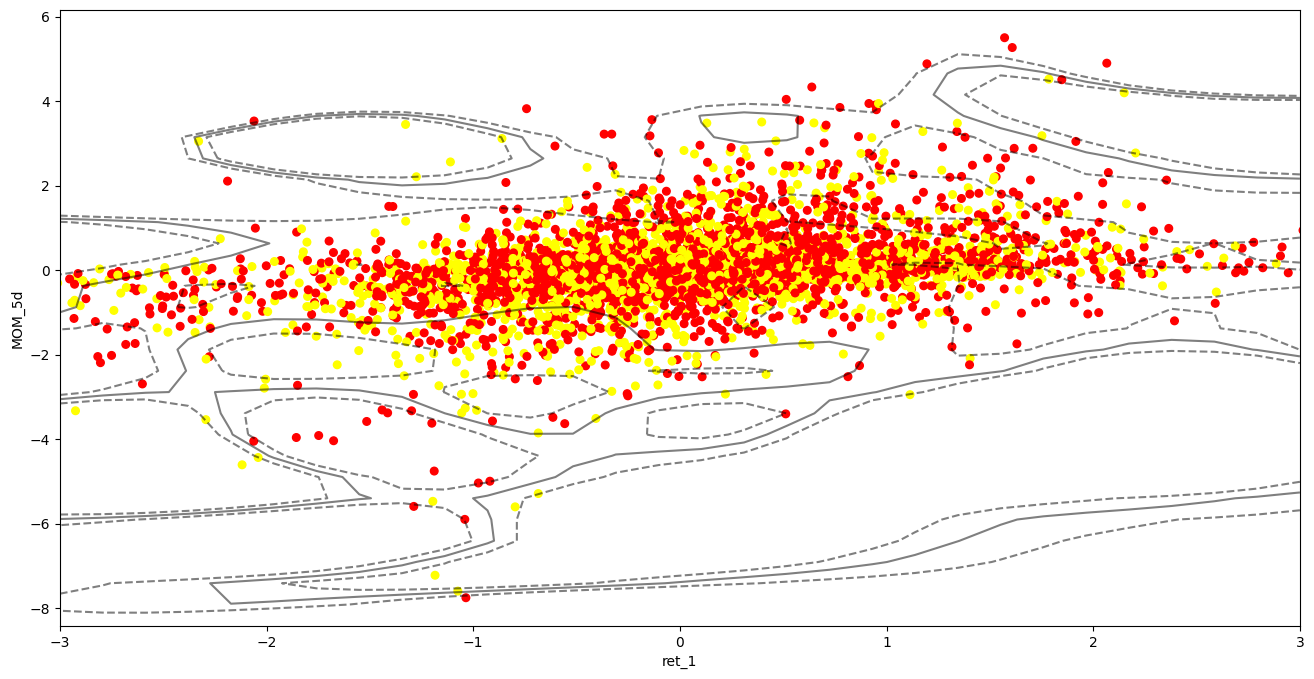

In [ ]:
plt.clf
plt.figure(figsize=(16, 8))
plt.scatter(feature_space_2D[:,0], feature_space_2D[:,1],
            c=train_y, s=30, cmap='autumn')
plot_svc_decision_function(SVM_2D_hard)
plt.xlabel('ret_1')
plt.ylabel('MOM_5d')

In [ ]:
soft_margin = 20
SVM_2D_soft = SVC(kernel='sigmoid',C=soft_margin, probability=True)
SVM_2D_soft.fit(feature_space_2D, train_y)

SVC(C=20, kernel='sigmoid', probability=True)

Text(0, 0.5, 'MOM_5d')

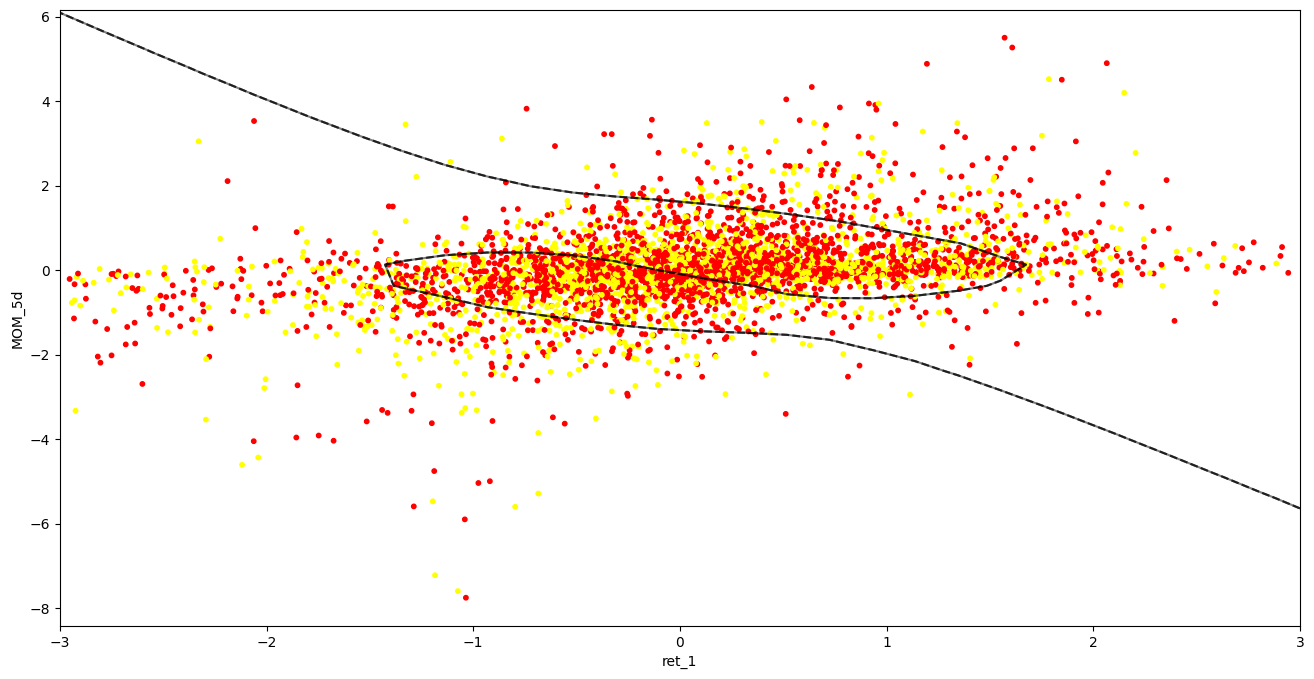

In [ ]:
plt.clf
plt.figure(figsize=(16, 8))
plt.scatter(feature_space_2D[:,0], feature_space_2D[:,1],
            c=train_y, s=10, cmap='autumn')
plot_svc_decision_function(SVM_2D_soft)
plt.xlabel('ret_1')
plt.ylabel('MOM_5d')

In [ ]:

soft_margin = 20
SVM_2D_soft= SVC(kernel='sigmoid',C=soft_margin, probability=True)
SVM_2D_soft = SVM_2D_soft.fit(train_X_scaled, train_y)
SVM_2D_soft_prediction = SVM_2D_soft.predict(test_X_scaled)

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
print('Classification report. Support Vector Machine, C:20.')
print()
print(classification_report(test_y, SVM_2D_soft_prediction))

Classification report. Support Vector Machine, C:20.

              precision    recall  f1-score   support

         0.0       0.55      0.81      0.66       269
         1.0       0.52      0.24      0.33       231

    accuracy                           0.55       500
   macro avg       0.54      0.52      0.49       500
weighted avg       0.54      0.55      0.50       500



In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
print('Confusion matrix. Support Vector Machine, C:20.')
print()
print(confusion_matrix(test_y, SVM_2D_soft_prediction))

Confusion matrix. Support Vector Machine, C:20.

[[218  51]
 [176  55]]


No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.554


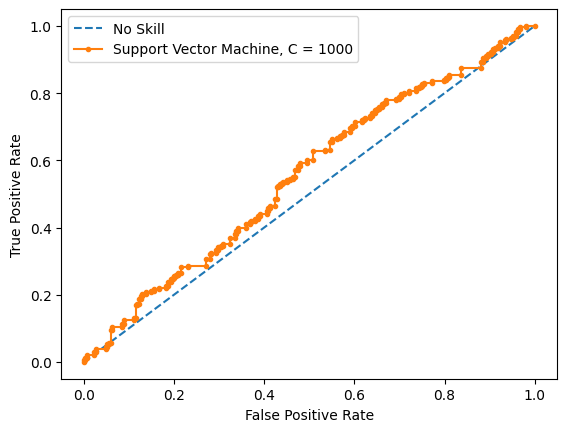

In [ ]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# Initialize a list of zeros representing the non-skilled model's probabilities
ns_probs = [0 for _ in range(len(test_y))]

# Generate predicted probabilities from the logistic regression model
lr_probs = SVM_2D_soft.predict_proba(test_X_scaled)

# Extract the probabilities for the positive class
lr_probs = lr_probs[:, 1]

# Compute the AUC scores for both the non-skilled and logistic regression models
ns_auc = roc_auc_score(test_y, ns_probs)
lr_auc = roc_auc_score(test_y, lr_probs)

# Print out the AUC scores for comparison
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# Calculate the ROC curves for both models
ns_fpr, ns_tpr, _ = roc_curve(test_y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_y, lr_probs)

# Plot the ROC curve for the non-skilled model (as a dashed line)
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')

# Plot the ROC curve for the logistic regression model (as a dotted line)
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Support Vector Machine, C = 1000')

# Label the x-axis and y-axis
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# Display the legend on the plot
pyplot.legend()

# Render the plot
pyplot.show()
